# Relationship of Gas Prices and Consumer Spending



In [243]:
# Mount your Google Drive. It will prompt you to log into your Google account.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [244]:
# Change the working directory to your project folder.
import os
drive_path = '/content/drive/MyDrive/Colab Notebooks/'
project_folder = 'Econ_0150_Project/'
full_path = drive_path + project_folder

# Check if the directory exists, and create it if it doesn't
if not os.path.exists(full_path):
    os.makedirs(full_path)
    print(f"Created directory: {full_path}")

os.chdir(full_path)
print(f"Changed current working directory to: {full_path}")

Changed current working directory to: /content/drive/MyDrive/Colab Notebooks/Econ_0150_Project/


## Step 0 | Imports and Setup

In [245]:
# Step 0 | Imports and Setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Make plots show up in the notebook
%matplotlib inline

#  options for tables
pd.set_option("display.max_columns", None)
pd.set_option("display.precision", 3)

## Step 1 | Data Preparation

Turn your data into something you can explore through data operations.

In [246]:
# Step 1 | Data Preparation

#Download data FRED

gas_url = "https://fred.stlouisfed.org/graph/fredgraph.csv?id=GASREGW"
pce_url = "https://fred.stlouisfed.org/graph/fredgraph.csv?id=PCECC96"
unemp_url = "https://fred.stlouisfed.org/graph/fredgraph.csv?id=UNRATE"

gas = pd.read_csv(gas_url)
pce = pd.read_csv(pce_url)
unemp = pd.read_csv(unemp_url)

#Convert Date column to datetime and set index

for df_item in [gas, pce, unemp]:
    df_item["observation_date"] = pd.to_datetime(df_item["observation_date"])
    df_item.set_index("observation_date", inplace=True)

#GASREGW is weekly and convert to monthly average

gas_monthly = gas.resample("ME").mean()

#Keep monthly PCE and unemployment as they are

pce_monthly = pce.resample("ME").mean()
unemp_monthly = unemp.resample("ME").mean()

#Merge all into a single DataFrame

data = gas_monthly.join([pce_monthly, unemp_monthly], how="inner")

#Rename columns to something readable

data = data.rename(
    columns={
        "GASREGW": "gas_price",
        "PCECC96": "real_pce",
        "UNRATE": "unemp_rate"
    }
)

#Restrict sample to 2000-01-01 to 2024-01-01

data = data.loc["2000-01-01":"2024-01-01"]

#Drop any missing values

data = data.dropna()

# Image

print("First 5 rows:")
display(data.head())

print("\nNumber of observations:", len(data))

First 5 rows:


,gas_price,real_pce,unemp_rate
observation_date,,,
2000-01-31,1.289,9039.743,4.0
2000-04-30,1.465,9124.152,3.8
2000-07-31,1.551,9211.569,4.0
2000-10-31,1.532,9292.050,3.9
2001-01-31,1.447,9325.751,4.2



Number of observations: 96


In [247]:
# Save your dataset after you've worked on it
data.to_csv('cleaned_data.csv')

## Step 2 | Exploratory Data Analysis

Summarize the main variables and relationships of interest.

Summary statistics:


,gas_price,real_pce,unemp_rate
count,96.000,96.000,96.000
mean,2.601,12006.568,5.808
std,0.791,1800.817,2.068
min,1.107,9039.743,3.400
25%,2.037,10853.726,4.375
50%,2.591,11605.593,5.250
75%,3.296,13351.762,6.525
max,4.559,15789.717,14.800


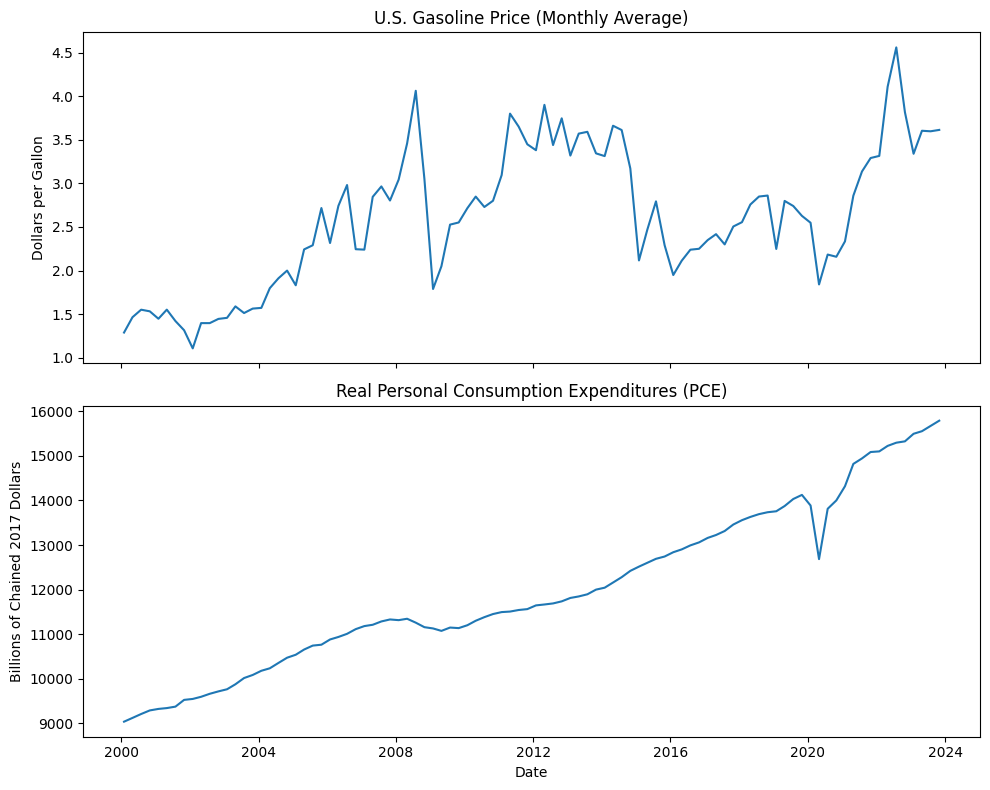

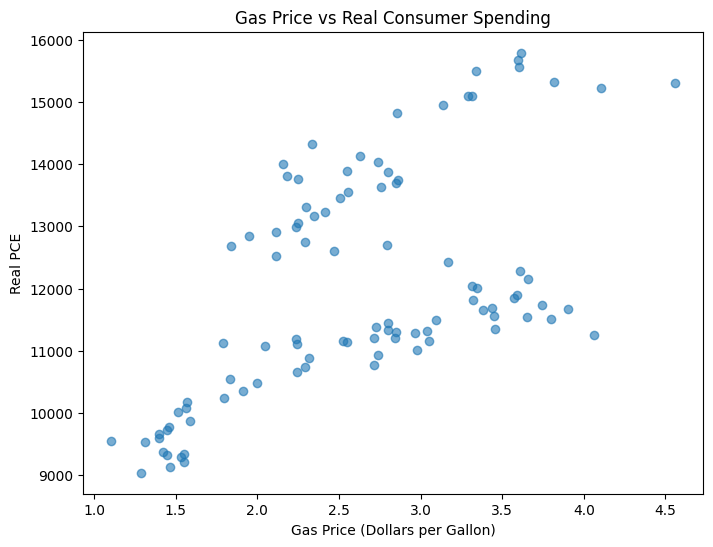

In [248]:
#Summary statistics
print("Summary statistics:")
display(data[["gas_price", "real_pce", "unemp_rate"]].describe())

#Line plot over time: gas price vs real PCE (two subplots)

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

axes[0].plot(data.index, data["gas_price"])
axes[0].set_title("U.S. Gasoline Price (Monthly Average)")
axes[0].set_ylabel("Dollars per Gallon")

axes[1].plot(data.index, data["real_pce"])
axes[1].set_title("Real Personal Consumption Expenditures (PCE)")
axes[1].set_ylabel("Billions of Chained 2017 Dollars")
axes[1].set_xlabel("Date")

plt.tight_layout()
plt.show()

#Scatterplot: gas price vs real PCE

plt.figure(figsize=(8, 6))
plt.scatter(data["gas_price"], data["real_pce"], alpha=0.6)
plt.xlabel("Gas Price (Dollars per Gallon)")
plt.ylabel("Real PCE")
plt.title("Gas Price vs Real Consumer Spending")
plt.show()

## Step 3 (Part 3 - 5)

Develop your statistical model.

1. Write down you null hypothesis
2. Write down your statistical model
3. Run your statistical model
4. Visualize your statistical model (if appropriate)

In [249]:

# There is no relationship between gasoline prices and real consumer spending.
#     In the regression, this means β1 = 0.

# Statistical model (in math / words):
# RealPCE_t = β0 + β1 * GasPrice_t + β2 * UnempRate_t + ε_t

# Run the model using statsmodels (OLS)

# Define dependent and independent variables
y = data["real_pce"]  # dependent variable
X = data[["gas_price", "unemp_rate"]]  # independent variables

# Add a constant term for the intercept
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Print full regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               real_pce   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     32.95
Date:                Fri, 12 Dec 2025   Prob (F-statistic):           1.52e-11
Time:                        20:39:12   Log-Likelihood:                -829.62
No. Observations:                  96   AIC:                             1665.
Df Residuals:                      93   BIC:                             1673.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9728.3061    612.464     15.884      0.0

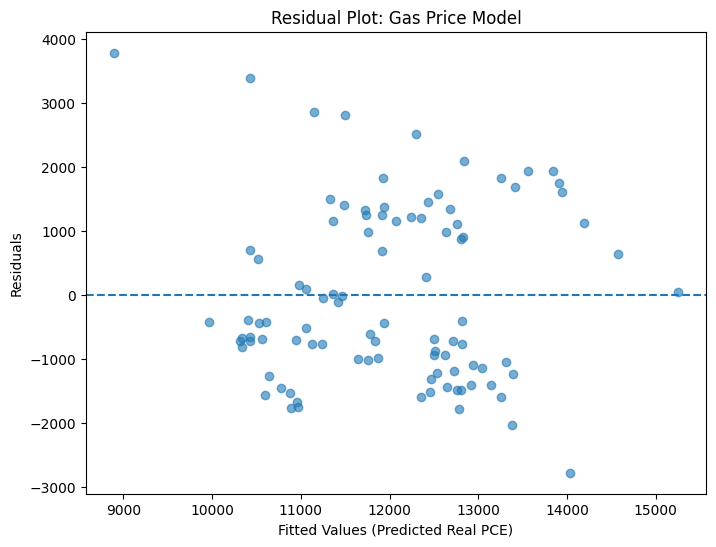

In [250]:
fitted_vals = model.fittedvalues
residuals = model.resid

plt.figure(figsize=(8, 6))
plt.scatter(fitted_vals, residuals, alpha=0.6)
plt.axhline(0, linestyle="--")
plt.xlabel("Fitted Values (Predicted Real PCE)")
plt.ylabel("Residuals")
plt.title("Residual Plot: Gas Price Model")
plt.show()

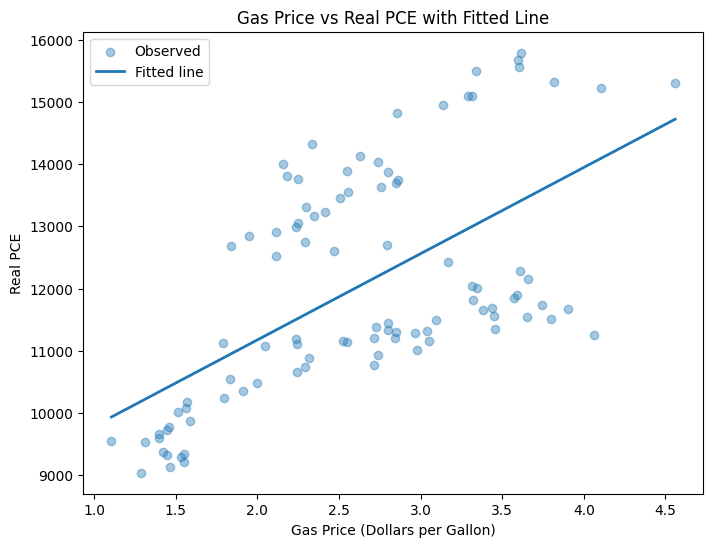

In [251]:
gas_grid = np.linspace(data["gas_price"].min(), data["gas_price"].max(), 100)
unemp_mean = data["unemp_rate"].mean()

X_line = pd.DataFrame({
    "const": 1.0,
    "gas_price": gas_grid,
    "unemp_rate": unemp_mean
})

y_line = model.predict(X_line)

plt.figure(figsize=(8, 6))
plt.scatter(data["gas_price"], data["real_pce"], alpha=0.4, label="Observed")
plt.plot(gas_grid, y_line, linewidth=2, label="Fitted line")
plt.xlabel("Gas Price (Dollars per Gallon)")
plt.ylabel("Real PCE")
plt.title("Gas Price vs Real PCE with Fitted Line")
plt.legend()
plt.show()

In [252]:
data.to_csv("gas_pce_unemp_monthly_2000_2024.csv")